## Team Members

Sebastian Cobuzzi - 20265330 <br>
Olivier Couture - 20286676 <br>
Rodrigo Alejandro Flores-Soto - 946250 <br>
Daly Mami - 20292497

# Libraries importation

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import matplotlib.image as mpimg
import plotly.graph_objects as go
from PIL import Image

# Function to retrieve and save play-by-play data for regular season matches

## *Initialization:*
A game_id variable is set to 1 to start with the first match of each season

## *Data Collection:*
 Since we don't know the exact number of games played in each season, We set a loop to continue downloading the data until it catches a 404 Error.

## *Data retrieval:*
The function constructs a URL using the access point and game ID to check if data for this game is already saved. If so, it skips the download. If not, it attempts to retrieve the game data from the URL.

## *If the event is a Goal:*
If the game data is successfully retrieved, the function extracts the play-by-play data, home and away team names, periods, and other relevant information. The extracted data is then saved as a JSON file in the specified directory.

## *Return:*
 The functions prints messages if an orrur occured while retrieving the data and a success message whenver the data was succesfully retreived and saved.

In [2]:
def retrieve_and_save_regular_season_data(season:int, data_directory:str, access_point:str):
    # set the ID of the first game of each season
    game_id = 1

    # We set a loop that continues to retreive data as long as we didn't finish from the season
    while True:
        # change the format of the ID to a 4 digit number
        game_id_str = f"{season}02{str(game_id).zfill(4)}"

        # pass the game ID to the acces_point's URL
        url = f"{access_point}{game_id_str}/feed/live/"

        # Set the filename of each game
        filename = os.path.join(data_directory, f"game_{game_id_str}.json")

        # If the file exists then we skip the download
        if os.path.exists(filename):
            print(f"File {filename} already exists. Skipping download.")
            game_id += 1
            continue

        # Check if we were able to access to the URL's data to download the play-by-play data
        response = requests.get(url)
        if response.status_code == 200:
            # retreive the required data
            playByPlay = response.json()['liveData']['plays']['allPlays']
            home_team = response.json()['gameData']['teams']['home']['name']
            away_team = response.json()['gameData']['teams']['away']['name']
            periods = response.json()['liveData']['linescore']['periods']

            # create and save the json informations into the file
            with open(filename, "w") as file:
                data_to_save = {"playByPlay": playByPlay,"periods": periods, "home": home_team, "away": away_team, "gameID": game_id_str}
                json.dump(data_to_save, file)
            print(f"Saved data for regular match ID {game_id_str} to {filename}")
        elif response.status_code == 404:
          print(f"404 NOT FOUND for Regular game ID {game_id_str}: {response.status_code}")
            # Game not found, exit the loop
          break
        else:
            print(f"Error in regular match ID {game_id_str}: {response.status_code}")
        # we proceed to the next game ID
        game_id += 1
    print(f"Data retrieval and saving completed for {season} regular season matches.")

# Function to retrieve and save play-by-play data for playoff matches

## *Iterations:*
The function is designed to retrieve and save playoff data for a given NHL season which is different than regular games IDs. we set loops to make sure to iterate over all of The NHL playoffs structure, which consists of 4 rounds,
The first round has 8 matchups, the second has 4, the third has 2, and the fourth (final) has 1. and then for all 7 possible games for each matchup.

## *Game ID Creation:*
A unique game ID is constructed for each game based on the season, playoff round, matchup, and game number.

## *Data retrieval:*
The function constructs a URL using the access point and game ID to check if data for this game is already saved. If so, it skips the download. If not, it attempts to retrieve the game data from the URL.

## *If the event is a Goal:*
If the game data is successfully retrieved, the function extracts the play-by-play data, home and away team names, periods, and other relevant information. The extracted data is then saved as a JSON file in the specified directory.

## *Return:*
 The functions prints messages if an error occured while retrieving the data and a success message whenver the data was succesfully retreived and saved.

In [3]:
def retrieve_and_save_playoff_data(season, data_directory, access_point):
    for playoff_round in range(1, 5):  # 4 playoff rounds
        # Set the number of matchups according to the round of the playoff
        matchups = 8 if playoff_round == 1 else 4 if playoff_round == 2 else 2 if playoff_round == 3 else 1
        for matchup in range(1, matchups + 1): # Access to each match of the playoffs
            for game_num in range(1, 8):  # NHL playoff series are best-of-seven
                game_id_str = f"{season}030{playoff_round}{matchup}{game_num}" # get the ID of the NHL playoffs games
                url = f"{access_point}{game_id_str}/feed/live/" # pass the game ID to the acces_point's URL
                # Set the filename of each game
                filename = os.path.join(data_directory, f"game_{game_id_str}.json")

                # If the file exists then we skip the download
                if os.path.exists(filename):
                    print(f"File {filename} already exists. Skipping download.")
                    continue

                # If it doesn't then we Check if we were able to access to the URL's data to download the play-by-play data
                response = requests.get(url)
                if response.status_code == 200:
                    # Retreive the required data
                    playByPlay = response.json()['liveData']['plays']['allPlays']
                    home_team = response.json()['gameData']['teams']['home']['name']
                    away_team = response.json()['gameData']['teams']['away']['name']
                    periods = response.json()['liveData']['linescore']['periods']
                    # create and save the json informations into the file
                    with open(filename, "w") as file:
                        data_to_save = {"playByPlay": playByPlay,"periods": periods, "home": home_team, "away": away_team, "gameID": game_id_str}
                        json.dump(data_to_save, file)
                    print(f"Saved data for playoffs game ID {game_id_str} to {filename}")
                elif response.status_code == 404:
                    print(f"404 NOT FOUND for playoffs game ID {game_id_str}: {response.status_code}")
                    # Game not found, exit the loop
                    break
                else:
                    print(f"Error for playoffs game ID {game_id_str}: {response.status_code}")

    print(f"Data retrieval and saving completed for {season} season playoffs matches.")

# Function to create the play-by-play dataframe from our downloaded json data

## Initialization:
 Two lists, shots and goals, are initialized to store information about shot and goal events respectively.
## File Traversal:
 The function iterates over all files in the data directory, filtering for files with a ".json" extension.
## File Processing:
Each JSON file is read into a variable.
The season and phase (Regular or Playoffs) are extracted from the filename.
The home and away team names are extracted from each file.
##Event Processing:
For each play in the variable:
We check if the event is a Goal or a Shot and then we extract the required informations from each one of these two events.
## DataFrame Creation:
After filling both shots and goals lists, We convert them into 2 seperate pandas DataFrames (shots_df and goals_df respectively).
## Return:
 The combined DataFrame is returned.

In [4]:
def create_hockey_dataframe(data_directory:str):
    # Initialize the shots and goals lists
    shots = []
    goals = []

    # Traverse through files in the specified directory
    for root, dirs, files in os.walk(data_directory):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, "r") as json_file:
                        playByPlays = json.load(json_file)
                    # Get the season and the phase_code from the filename
                    season = file[5:9]
                    phase_code = file[9:11]
                    if phase_code == "02":
                      phase = 'Regular'
                    else:
                      phase = 'Playoffs'
                    # Get the home and away team names
                    home = playByPlays['home']
                    away = playByPlays['away']


                    # From each play of the play-by-play data we take the required informations
                    for play in playByPlays['playByPlay']:
                        if play['result']['event'] == 'Goal': # We retrieve the informations we need from the Goal plays

                            # Parse through all the playerTypes and only retrieve scorers and goalies (ignoring the assisters if they exist) otherwise we replace them by a NaN
                            scorer = next((player['player']['fullName'] for player in play['players'] if player.get('playerType') == 'Scorer'), np.NaN)
                            goalie = next((player['player']['fullName'] for player in play['players'] if player.get('playerType') == 'Goalie'), np.NaN)
                            period = play['about']['period'] # We retrieve the play period information
                            empty_net = play['result'].get('emptyNet', np.nan)  # Check if 'emptyNet' exists and replace it with a NaN if it doesn't
                            secondary_type = play['result'].get('secondaryType',np.nan)  # Check if 'secondaryType' exists and replace it with a NaN if it doesn't
                            x = play['coordinates'].get('x',np.nan)  # Check if 'x' exists and replace it with a NaN if it doesn't
                            y = play['coordinates'].get('y', np.nan) # Check if 'y' exists and replace it with a NaN if it doesn't

                            # We check the team's rink side based on the first period chosen sides (they swap sides after each period)
                            per = int(period)-1
                            if per % 2 == 0:
                              if play['team']['name'] == home:
                                rink_side = playByPlays['periods'][0]['home'].get('rinkSide', np.nan) # we replace the missing values by nan
                              else:
                                rink_side = playByPlays['periods'][0]['away'].get('rinkSide', np.nan) # we replace the missing values by nan
                            else :
                              if play['team']['name'] == home:
                                rink_side = playByPlays['periods'][1]['home'].get('rinkSide', np.nan) # we replace the missing values by nan
                              else:
                                rink_side = playByPlays['periods'][1]['away'].get('rinkSide', np.nan) # we replace the missing values by nan


                            # We add to the list of goals the data extracted from the json file
                            goals.append([
                                f'{season}-{int(season[2:])+1}', playByPlays['gameID'], phase,
                                period, play['about']['periodTime'],
                                play['about']['eventId'],
                                play['team']['name'],
                                rink_side,
                                x, y,
                                scorer, goalie,
                                secondary_type,
                                empty_net,'Goal',
                                play['result']['strength']['name']
                            ])


                        elif play['result']['event'] == 'Shot': # We retreive the informations we need from the Shots plays
                          # Parse through all the playerTypes and only retreive shooters and goalies if they exist otherwise we replace them by a NaN
                          shooter = next((player['player']['fullName'] for player in play['players'] if player.get('playerType') == 'Shooter'), np.NaN)
                          goalie2 = next((player['player']['fullName'] for player in play['players'] if player.get('playerType') == 'Goalie'), np.NaN)
                          period = play['about']['period']# We retreive the play period information
                          secondary_type = play['result'].get('secondaryType',np.nan)  # Check if 'secondaryType' exists and replace it with a NaN if it doesn't
                          x = play['coordinates'].get('x', np.nan)  # Check if 'x' exists and replace it with a NaN if it doesn't
                          y = play['coordinates'].get('y', np.nan)  # Check if 'y' exists and replace it with a NaN if it doesn't

                          # We check the team's rink side based on the first period chosen sides (they swap sides after each period)
                          per = int(period)-1
                          if per % 2 == 0:
                            if play['team']['name'] == home:
                              rink_side = playByPlays['periods'][0]['home'].get('rinkSide', np.nan) # we replace the missing values by nan
                            else:
                              rink_side = playByPlays['periods'][0]['away'].get('rinkSide', np.nan) # we replace the missing values by nan
                          else :
                            if play['team']['name'] == home:
                              rink_side = playByPlays['periods'][1]['home'].get('rinkSide', np.nan) # we replace the missing values by nan
                            else:
                              rink_side = playByPlays['periods'][1]['away'].get('rinkSide', np.nan) # we replace the missing values by nan
                          # We add to the list of shots the data extracted from the json file
                          shots.append([
                              f'{season}-{int(season[2:])+1}', playByPlays['gameID'],phase,
                              period, play['about']['periodTime'],
                              play['about']['eventId'],
                              play['team']['name'],
                              rink_side,
                              x, y,
                              shooter, goalie2,
                              secondary_type,
                              'False','Shot'
                          ])
                except KeyError as e:
                    print(f"KeyError in file: {file_path}, Key: {str(e)}")

    # Convert the data into pandas DataFrames
    shots_df = pd.DataFrame(shots, columns=["Season","GameID","Phase", "Period", "PeriodTime", "PlayID", "Team", 'RinkSide', "XPoint", "YPoint", "Shooter", "Goalie", "ShotType", "EmptyNet", "Event"])
    goals_df = pd.DataFrame(goals, columns=["Season","GameID","Phase", "Period", "PeriodTime", "PlayID", "Team", 'RinkSide', "XPoint", "YPoint", "Shooter", "Goalie", "ShotType", "EmptyNet", "Event", "Situation"])


    # Combine the DataFrames into a single DataFrame
    combined_df = pd.concat([shots_df, goals_df], ignore_index=True)

    return combined_df

# Execute the functions to download the play-by-play data and create the dataframe

In [5]:
# Main access point to reach the data
access_point = "https://statsapi.web.nhl.com/api/v1/game/"

# Define the range of seasons (from 2016 to 2020)
seasons = range(2016, 2021)

# Define a main directory name where we will store the data (json)
data_directory = 'NHLGameData'

# Create the main directory (if it's not already created)
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

# Retrieve and save game data for each season
for season in seasons:
    retrieve_and_save_regular_season_data(season, data_directory, access_point)
    retrieve_and_save_playoff_data(season, data_directory, access_point)

# Read the created dataframe into the variable df
df = create_hockey_dataframe(data_directory)

Streaming output truncated to the last 5000 lines.
Saved data for regular match ID 2017020114 to NHLGameData/game_2017020114.json
Saved data for regular match ID 2017020115 to NHLGameData/game_2017020115.json
Saved data for regular match ID 2017020116 to NHLGameData/game_2017020116.json
Saved data for regular match ID 2017020117 to NHLGameData/game_2017020117.json
Saved data for regular match ID 2017020118 to NHLGameData/game_2017020118.json
Saved data for regular match ID 2017020119 to NHLGameData/game_2017020119.json
Saved data for regular match ID 2017020120 to NHLGameData/game_2017020120.json
Saved data for regular match ID 2017020121 to NHLGameData/game_2017020121.json
Saved data for regular match ID 2017020122 to NHLGameData/game_2017020122.json
Saved data for regular match ID 2017020123 to NHLGameData/game_2017020123.json
Saved data for regular match ID 2017020124 to NHLGameData/game_2017020124.json
Saved data for regular match ID 2017020125 to NHLGameData/game_2017020125.json
S

# Interactive debugging tool

## Object:
The event visualizer is designed in a class in order to easily pass parameter over many different widets easily (ex. game ids change with season_type and year).

## Availability of data:
The tool merely scans the available files in path which match the `game_<game_id>.json` notation. In order to get information about events that happened during a game, the json file is opened and it's content is read in the tool. The content of only one file is saved at once in the tool.

## ipywidgets:
3 ipywidgets are available in the visualizer tool, namely the choice of season type, the season year (which depends on season type) and game_id (which depends on both season year and type). As a new value is selected in one of the widgets, the update method will run, ensuring the range of choices available with the widgets are updated.

## interact plot:
Outside of these 3 widgets, the tool interacts with the plot_event method which plots the event on the rink. The interact function creates the event_id widgets automatically and links it with the plot.

Since the interact is outside of the previously mentionned widgets, if a change is made in those, it will not reflect immediatly on the plot. Instead the plot will need to be refreshed by changing the event_id.

### If the event has coordinates:
The event will be plotted on the rink. The event description, period and time remaining to the period will act as the title of the plot. The team names come from the json file and we disregard which team caused the event. A black dot representing the coordinates of the event is placed on the rink.

### If it does not have coordinates:
The event will be printed in json format. Some events, like period changes, do not have coordinates but are still relevant to explore in the visualizer tool. However, due to the nature of the `try: except:` statement, if any unexpected error happen during the plotting of the event, it will be caught in the except. While this was not the original intention of this statement, it was found to be useful as a diagnosis tool.

In [7]:
class event_visualizer(object):
    def __init__(self, path, img_path):
        self.path = path
        self.rink_img = mpimg.imread(img_path)
        self.initialize_values()
        self.create_widgets()

    def initialize_values(self):
      # Sets a couple of values to default
            self.season_type = '02' # init only
            self.games_list = self.get_games_list()
            self.year_list = self.get_year_list()
            self.year = self.year_list[0] # init only
            self.game_ids = self.get_games_in_season()
            self.game_id = self.game_ids[0] # init only
            self.file = self.read_file()
            self.events = self.file['playByPlay']
            self.event_id = 0 # init only

    def create_widgets(self):
      # Creates and draws widgets for season type, year and game_id.
        self.w_season_type = widgets.ToggleButtons(
            options=[('Regular', '02'), ('Playoff', '03')],
            description='Season type'
            )
        self.w_season_year = widgets.ToggleButtons(
            options=self.year_list,
            description="Season year"
            )
        self.w_game_ids = widgets.SelectionSlider(
            options=self.game_ids,
            value=self.game_ids[0],
            description="Game id"
            )

        # if a value changes in these widgets, self.update will run
        self.w_season_year.observe(self.update, 'value')
        self.w_season_type.observe(self.update, 'value')
        self.w_game_ids.observe(self.update, 'value')

        self.grid = widgets.GridspecLayout(3,1)
        self.grid[0,0] = self.w_season_type
        self.grid[1,0] = self.w_season_year
        self.grid[2,0] = self.w_game_ids

    def update(self, *args):
        # updates the widgets and events with the new values from the widgets
        self.season_type = self.w_season_type.value
        self.games_list = self.get_games_list()

        self.year_list = self.get_year_list()
        self.w_season_year.options = self.year_list
        self.year = self.w_season_year.value

        self.game_ids = self.get_games_in_season()
        self.w_game_ids.options = self.game_ids
        self.game_id = self.w_game_ids.value

        self.file = self.read_file()
        self.events = self.file['playByPlay']

    def get_games_list(self):
        # returns the list of games that match the season type
        games_list = os.listdir(self.path)
        return [ i[5:9] + "_" + i[11:15] for i in games_list if i[9:11]==self.season_type]

    def get_year_list(self):
        # returns the list of unique years from games_list
        year_list = list(set( [i.split("_")[0] for i in self.games_list] ))
        year_list.sort()
        return year_list

    def get_games_in_season(self):
        # returns the list of game_ids for a certain year in games_list
        season_games = [ i.split("_")[1] for i in self.games_list if i[0:4]==self.year ]
        season_games.sort() #should be by default but still safer
        return season_games

    def read_file(self):
      # returns the content of the json file
        f = open(self.path + "game_{year}{season}{id}.json".format(year=self.year,
                                                                   season=self.season_type,
                                                                   id=self.game_id)
                )
        data = json.load(f)
        return data

    def plot_event(self, event_id):
      # plots the rink event or prints the event
        try :
            x = self.events[event_id]['coordinates']['x']
            y = self.events[event_id]['coordinates']['y']

            title = self.events[event_id]['result']['description']
            time = self.events[event_id]['about']['periodTime']
            period = self.events[event_id]['about']['period']

            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.imshow(self.rink_img, extent=[100, -100, 42.5, -42.5])
            ax.set_xlim(-100, 100)
            ax.set_xlabel("feet")
            ax.set_ylim(-42.5, 42.5)
            ax.set_ylabel("feet")
            ax.set_title("{description}\n{time} P-{period}\n".format(description=title,
                                                                   time=time,
                                                                   period=period)
            )
            ax.plot(x,y, 'ok')

            plt.figtext(0.15, 0.8, self.file['home']) # positions for these are hard coded since they shouldn't change
            plt.figtext(0.65, 0.8, self.file['away'])

            plt.show()
        except:
            print( json.dumps(self.events[event_id], indent=4) )

game_viz = event_visualizer("NHLGameData/", "nhl_rink.png")
display(game_viz.grid)

widgets.interact(game_viz.plot_event, event_id=(0, len(game_viz.events)-1))

GridspecLayout(children=(ToggleButtons(description='Season type', layout=Layout(grid_area='widget001'), option…

interactive(children=(IntSlider(value=178, description='event_id', max=357), Output()), _dom_classes=('widget-…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

# Function to add the Shot Distance column

For each line of the dataset, we verify if both X and Y Points are available. If they are both available then we calculate the distance between the shot and the oponent's net and if one or both of them are not available then we return a NaN.

In [8]:
# calculate distance function
def calculate_distance(row):
  if np.isnan(row['XPoint']) or np.isnan(row['YPoint']):
      return np.nan  # replace with nans if we couldn't calculate the distance
  else:
      # Euclidean distance
    if row['RinkSide'] == "right":
      # oponents net coordinates
      X_net = -89  # X coordinate of the oponents net
      Y_net = 0   # Y coordinate of the oponents net
      X_distance = row['XPoint'] - X_net
      Y_distance = row['YPoint'] - Y_net
    else :
      # oponents net coordinates
      X_net = 89  # X coordinate of the oponents net
      Y_net = 0   # Y coordinate of the oponents net
      X_distance = row['XPoint'] - X_net
      Y_distance = row['YPoint'] - Y_net
  return int(math.sqrt(X_distance**2 + Y_distance**2))

# Add the 'Distance' column to the DataFrame
df['Distance'] = df.apply(calculate_distance, axis=1)

# Download the updated dataframe
df.to_csv("hockey_data.csv", index=False)

# Function to visualize the number of scored and missed shots for each shot type

## *Utility:*
This function shows the number of missed shots and the number of goals for each type of shot for a chosen season by retrieving the informations for each season in a seperate dataframe and aggregating the number of shots and goals based on the shot type.

## *Plot's Legend:*
*Red:* Represents the missed shots.<br>
*Green:* Represents the scored goals.

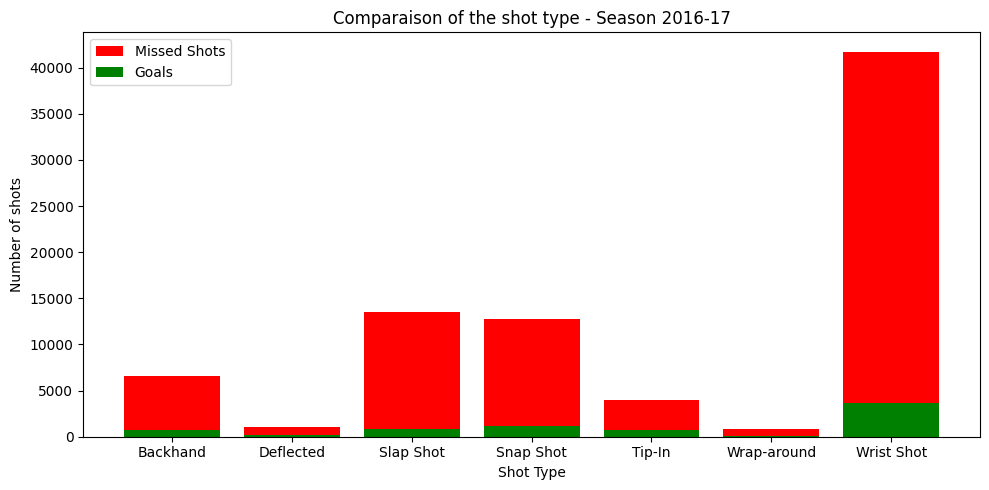

In [9]:
def shots_goals_statistics(df: pd.DataFrame, season:str):
    season_to_plot = f'{season}-{int(season[2:])+1}'

    # Get the informations of the given season
    filtered_df = df[df['Season'] == season_to_plot]

    # Group by the type of the shot and the Event (goal or shot(miss)) and count the occurrences of each combination
    data_to_plot = filtered_df.groupby(['ShotType', 'Event']).size().unstack(fill_value=0)

    # rename the columns
    data_to_plot.columns = ['Goals', 'Shots']

    # Calculate the total number of shots + goals for each shot type
    data_to_plot['Total'] = data_to_plot['Shots'] + data_to_plot['Goals']

    # Set up the matplotlib configurations
    plt.figure(figsize=(10, 5))

    plt.bar(data_to_plot.index, data_to_plot['Total'], label='Missed Shots', color='red')
    plt.bar(data_to_plot.index, data_to_plot['Goals'], label='Goals', color='green')
    plt.xlabel('Shot Type')
    plt.ylabel('Number of shots')
    plt.title(f"Comparaison of the shot type - Season {season_to_plot}")
    plt.legend()
    plt.tight_layout()
    plt.show()

shots_goals_statistics(df,'2016')

# Function to visualize the probabilty of a shot to turn into a goal from specific distance

## *Utility:*
This function visualizes the relationship between the distance from which a shot is taken and the probability of that shot turning into a goal.

## *Plotting:*
The function creates a line plot with shot distance on the x-axis and goal probability on the y-axis. The plot is marked with green dots to represent individual data points for each distance.

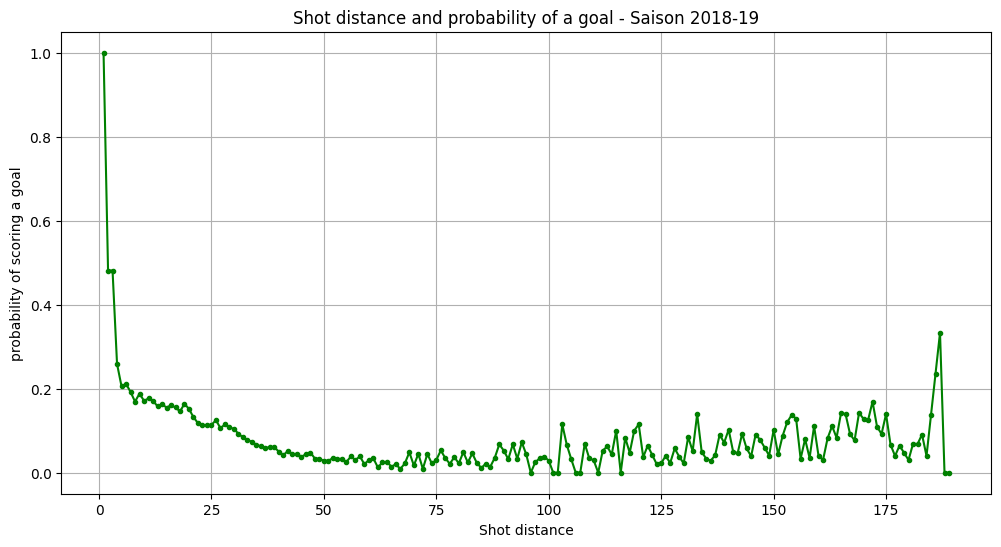

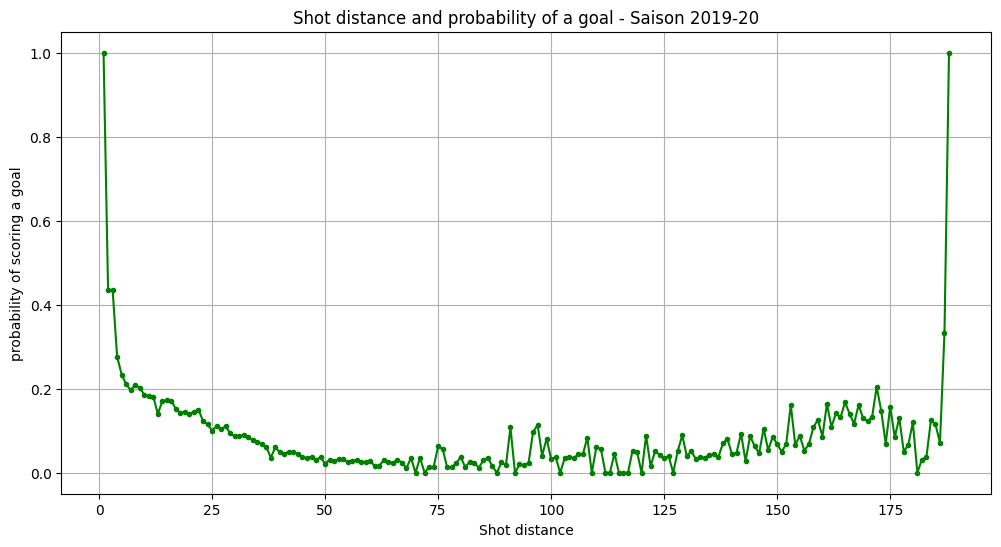

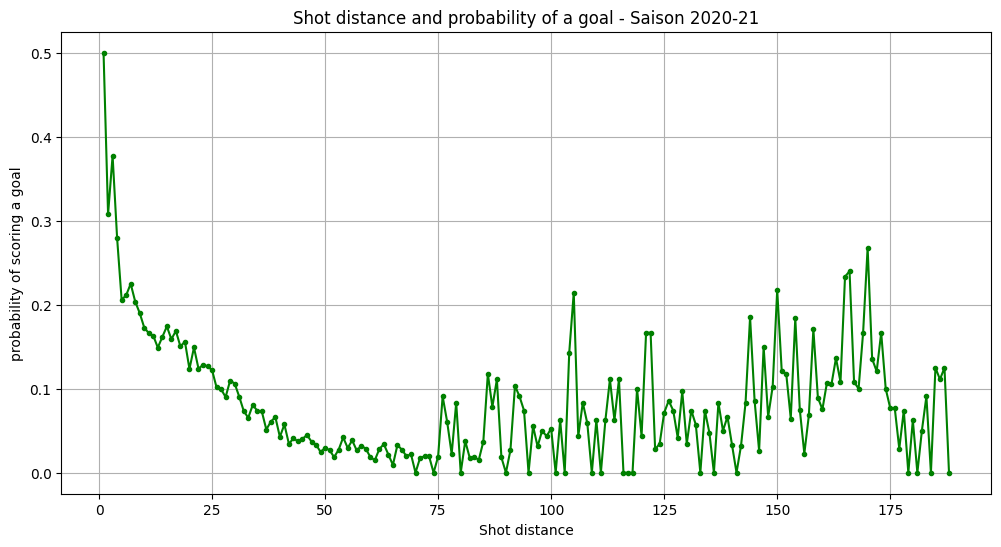

In [10]:
def distance_goal_probability(seasons):
    # Create 3 line plots, one for each season
    for season in seasons:
        filtered_df = df[df['Season'] == season]
        distance_prob_df = filtered_df.groupby(['Distance', 'Event']).size().unstack(fill_value=0)
        distance_prob_df['Goal Probability'] = distance_prob_df['Goal'] / (distance_prob_df['Goal'] + distance_prob_df['Shot'])

        # Sorting by distance for a continuous line plot
        distance_prob_df = distance_prob_df.sort_index()

        plt.figure(figsize=(12, 6))
        plt.plot(distance_prob_df.index, distance_prob_df['Goal Probability'], marker='.', c='green')
        plt.xlabel('Shot distance')
        plt.ylabel('probability of scoring a goal')
        plt.title(f'Shot distance and probability of a goal - Saison {season}')
        plt.grid(True)
        plt.show()

# Seasons to analyze
seasons = ['2018-19', '2019-20', '2020-21']

distance_goal_probability(seasons)

# Function to visualize the percentage of the goals from each location on the ice for each shot type

## *Utility:*
This function visualizes the percentage of the shots that have been turned into goals for each range of distances, by bining the range of distances, for each type of shots.

## *Plotting:*
The function creates a heatmap plot with shot distance on the x-axis and shot type on the y-axis. Each case represents the percentage of each type of shot for a specific range of distance.

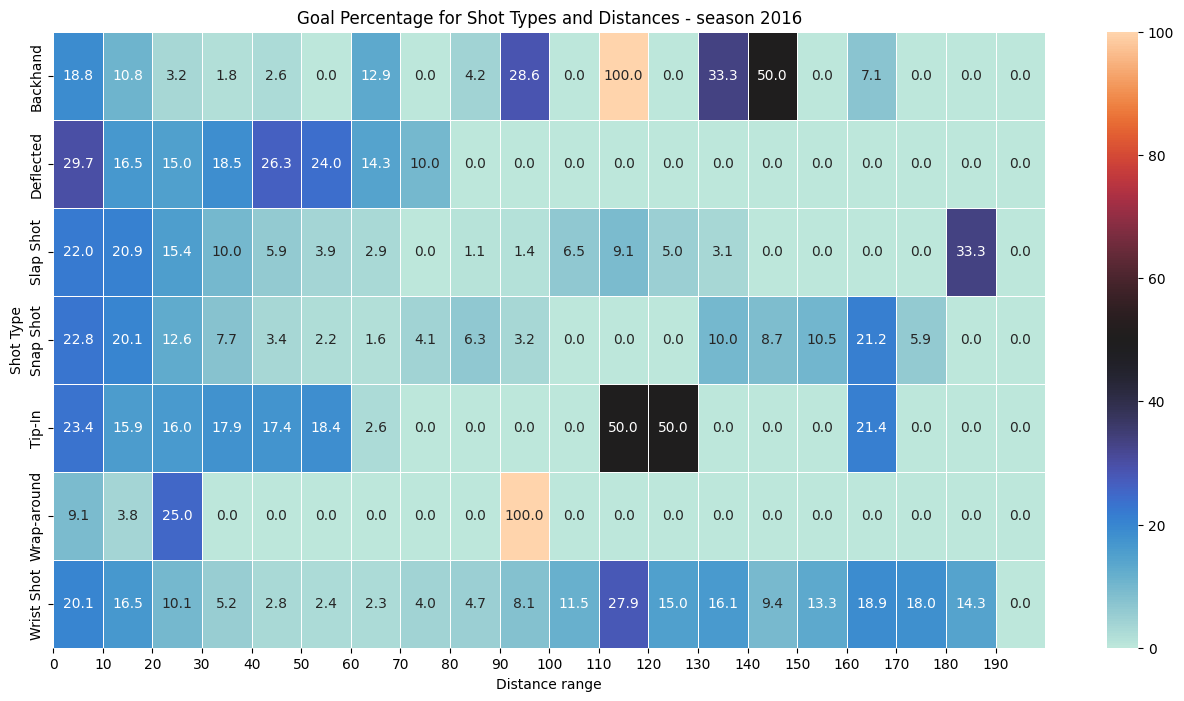

In [11]:
def visualize_goal_percentages(dataframe, season):
    # Convert the season parameter to the format used in the dataframe
    season_str = f"{season}-{str(season + 1)[-2:]}"

    # Filter the dataframe for the specified season
    season_df=dataframe.copy()
    season_df = season_df[season_df['Season'] == season_str]

    # Create distance bins covering the range from 0 to 200
    bin_intervals = range(0, 201, 10)
    season_df['Distance_Bin'] = pd.cut(season_df['Distance'], bins=bin_intervals, right=False)

    # Group by 'ShotType' and 'Distance_Bin' and calculate the percentage of 'Goal' events within each group
    grouped_df = (
        season_df.groupby(['ShotType', 'Distance_Bin', 'Event'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )
    grouped_df['Total'] = grouped_df['Shot'] + grouped_df['Goal']
    grouped_df['Goal_Percentage'] = (grouped_df['Goal'] / grouped_df['Total']) * 100

    # Prepare data for heatmap: Goal_Percentage with Distance_Midpoint on x-axis and ShotType on y-axis
    grouped_df['Distance_Midpoint'] = grouped_df['Distance_Bin'].apply(lambda interval: interval.left + 5)  # Adjusted to represent from 0 to 190
    heatmap_data = grouped_df.pivot(index='ShotType', columns='Distance_Midpoint', values='Goal_Percentage').fillna(0) # on remplace les Nans par des 0 pour éviter les espaces vides

    # Draw a heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(heatmap_data, cmap='icefire', annot=True, fmt=".1f", linewidths=.5)

    plt.title(f'Goal Percentage for Shot Types and Distances - season {season}')
    plt.xlabel('Distance range')
    plt.ylabel('Shot Type')
    plt.xticks(ticks=range(0, 20), labels=range(0, 191, 10))  # Adjusted to represent from 0 to 200
    plt.show()

# Execute the function to visualize goal percentages using a heatmap for a given season.
visualize_goal_percentages(df, 2016)

# Function to compute the excess shot rate of a team compared to the league average in a given season

<br>

## *Binning and rink division*
The binning method is used to divide the rink into different subareas of a larger area. <br><br>
The area we are considering in this shot map is the offensive zone of the ice (excluding area behind the net). To accomplish this, we took into consideration the starting rink side (in that period) of the shooter to filter shots outside of the offensive zone.<br><br>
A bin size of 3 was chosen, meaning when counting number of shots, we binned them into areas of 3 square feet on the rink (offsensive zone).<br><br>

## *Definition of excess shot rate per hour*

The number of shots in each zone were then transformed to shot rates which were calculated by hour. Since each game lasts 60 minutes, we can divide by the number of games to find the shot rate per hour. After computing the rates in each zone for both the league and teams, the excess is simply the difference between a given team and the league's average. <br><br>

A positive excess shot rate means that the team took more shots than the league average at a given location.<br>
A negative excess shot rate means the opposite.<br><br>

In [12]:
def compute_exceess_shot_rate(df, season):
  # we have to make these values a little bigger because they get sliced during binning
  # in any case, we put a range in the plot to only include (90 > 'XPoint' > 0) & (-42.5 > 'YPoint' > 42.5)
  offensive_rink_length = 95  # goal line to center ice
  offensive_rink_width = 93   # boards to boards
  bin_size = 3

  df = df[df['Season'] == season]

  # calculate number of games played in the given season - we are assuming that there was at least one shot in every game played
  league_total_games = df['GameID'].nunique()
  num_teams = df['Team'].nunique()
  team_total_games = (league_total_games / num_teams) * 2

  # remove shots from defensive zone
  offensive_df = df.drop(df[(df['RinkSide'] == 'right') & (df['XPoint'] > 0)].index)
  offensive_df = offensive_df.drop(offensive_df[(offensive_df['RinkSide'] == 'left') & (offensive_df['XPoint'] < 0)].index)

  # remove shots from behind the net
  offensive_df = offensive_df.drop(offensive_df[(offensive_df['XPoint'] > 90) | (offensive_df['XPoint'] < -90)].index)

  # create bins to divide rink into zones
  x_bins = np.arange(-(offensive_rink_width / 2), (offensive_rink_width / 2) + 1, bin_size)
  y_bins = np.arange(0, offensive_rink_length + 1, bin_size)

  offensive_df['XPointShotMap'] = offensive_df['XPoint'].abs()  # we also have to count the offensive shots on the LHS of the rink (-ve XPoint)
  offensive_df['XBin'] = pd.cut(offensive_df['YPoint'], bins=x_bins, labels=x_bins[:-1])
  offensive_df['YBin'] = pd.cut(offensive_df['XPointShotMap'], bins=y_bins, labels=y_bins[:-1])

  # By league (shot rate)
  league_shot_rate = offensive_df.groupby(['XBin', 'YBin'])['PlayID'].count().reset_index()
  league_shot_rate.columns = ['XBin', 'YBin', 'TotalShots']
  league_shot_rate['ShotRatePerHour'] = league_shot_rate['TotalShots'] / league_total_games

  # By team (shot rate)
  team_shot_rate = offensive_df.groupby(['Team', 'XBin', 'YBin'])['PlayID'].count().reset_index()
  team_shot_rate.columns = ['Team', 'XBin', 'YBin', 'TotalShots']
  team_shot_rate['ShotRatePerHour'] = team_shot_rate['TotalShots'] / team_total_games

  # Calcuate excess shot rate for each team compared to league average
  merged_shot_rate = team_shot_rate.merge(league_shot_rate, on=['XBin', 'YBin'], suffixes=('Team', 'League'))
  merged_shot_rate['ExcessShotRatePerHour'] = merged_shot_rate['ShotRatePerHourTeam'] - merged_shot_rate['ShotRatePerHourLeague']

  return merged_shot_rate

# Function to show contour plots of excess shot rate (shot map)

## *Functionality*
The shot maps are plotted for each season between 2016-17 and 2020-21 (inclusive).<br>
The interactive graph makes it possible to view the shot map for each team in any of the given seasons.<br><br>

## *Legend*
*Red:* Area from which a team has a greater shot rate per hour than the league average<br>
*Blue:* Area from which a team has a lower shot rate per hour than the league average<br>
*White:* Area from which a team has an equal shot rate per hour than the league average


In [13]:
def get_pivot_values(df):
  return df.pivot_table(index='XBin', columns='YBin', values='ExcessShotRatePerHour').values.tolist()

def plot_shot_map(df, season, image):

  nhl_shot_rate = compute_exceess_shot_rate(df, season)

  # get all teams playing in selected season
  team_names = nhl_shot_rate['Team'].unique()

  # get contour data for first team and pivot to plot
  shot_rate_pivot_team_0 = nhl_shot_rate[nhl_shot_rate['Team'] == team_names[0]]
  shot_rate_pivot_team_0 = shot_rate_pivot_team_0.pivot_table(index='XBin', columns='YBin', values='ExcessShotRatePerHour')

  colorscale = [
      [0, 'blue'],
      [0.5, 'white'],
      [1, 'red']
  ]

  # plot contour
  fig = go.Figure(data =
      go.Contour(
          z=shot_rate_pivot_team_0.values.tolist(),
          x=shot_rate_pivot_team_0.index.values.tolist(),
          y=shot_rate_pivot_team_0.columns.values.tolist(),
          zmin=-0.2,
          zmax=0.2,
          colorscale=colorscale,
          opacity=0.7,
          colorbar=dict(
              title='Excess weighted<br>  shots per hour',
              titlefont=dict(
                  size=14,
                  family='Arial, sans-serif')
          )
      ))

  # add image
  fig.add_layout_image(
          dict(
              source= Image.open(image),
              xref="x",
              yref="y",
              x=-42.5,
              y=0,
              sizex=85,
              sizey=90,
              opacity=1,
              sizing='stretch',
              layer="below")
  )

  # add dropdown
  buttons = list([])
  for team in team_names:
      button = dict(
          label=team,
          method='restyle',
          args=[dict(
                z=[get_pivot_values(nhl_shot_rate[nhl_shot_rate['Team'] == team])],   # get selected team's data
              )]
      )
      buttons.append(button)


  fig.update_layout(
      updatemenus=[dict(
              direction="down",
              pad={"r": 10, "t": 10},
              showactive=True,
              x=1,
              xanchor="left",
              y=1.13,
              yanchor="top",
              buttons=buttons
      ),]
  )

  # titles and sizing
  fig.update_layout(
      title='NHL Season ' + season,
      title_x=0.4,
      xaxis_title='Distance from center of rink (ft)',
      yaxis_title='Distance from goal line (ft)',
      yaxis=dict(range=[90,0]),
      xaxis=dict(range=[-42.5,42.5]),
      width=775,
      height=800
  )

  fig.show()
  fig.write_html('shotmap_' + season)



df = pd.read_csv("hockey_data.csv")

# compute shot map from seasons 2016-17 to 2020-21
for i in range(16, 21):
  year1 = 2000 + i
  year2 = i + 1
  season = str(year1) + '-' + str(year2)
  plot_shot_map(df, season, 'nhl_half_rink.png')

<ipython-input-13-b63be0bd7870>:97: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("hockey_data.csv")
